In [1]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig

from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

DATA_PATH = "./data/"

In [2]:
with open(DATA_PATH + "tags.txt", "r") as f:
    data = f.readlines()
print(data)

['#간식좋아함\n', '#장난감좋아함\n', '#고령의펫\n', '#추위탐\n', '#더위탐\n', '#체중조절필요\n', '#야행성펫\n', '#산책좋아함\n', '#운동러버\n', '#소프트간식굿\n', '#딱딱한간식굿\n', '#푹신한물건굿\n', '#피부민감\n', '#건조한피부\n', '#빛민감\n', '#순한샴푸필수\n', '#온도민감\n', '#털빠짐주의\n', '#사냥본능\n', '#냄새에민감\n', '#물놀이좋아함\n', '#새벽활동러\n', '#높은곳좋아함\n', '#털관리필수\n', '#집을좋아함\n', '#혼자놀기왕\n', '#사교성좋음\n', '#곤충스낵러버\n', '#다이어트필요\n', '#기술학습빠름\n', '#움직이기싫음\n', '#하루종일놀기\n', '#배변훈련필요\n', '#소리좋아함\n', '#감촉민감\n', '#관절보호필요\n', '#인형좋아함\n', '#자주목욕필요\n', '#거친털\n', '#부드러운털\n', '#숲속좋아함\n', '#모래놀이팬\n', '#길들이기쉬움\n', '#길들이기힘듦\n', '#소리에예민\n', '#무서움잘느낌\n', '#다양한맛탐색\n', '#피부알러지있음\n', '#스트레스관리필요']


In [3]:
for idx, word in enumerate(data):
    word_temp = str()
    word_temp = word.replace("\n", "")
    word_temp = word_temp.replace(" ", "")

    if word_temp == "" or word_temp == " " or word_temp == "\n":    continue
    data[idx] = word_temp
print(data)

['#간식좋아함', '#장난감좋아함', '#고령의펫', '#추위탐', '#더위탐', '#체중조절필요', '#야행성펫', '#산책좋아함', '#운동러버', '#소프트간식굿', '#딱딱한간식굿', '#푹신한물건굿', '#피부민감', '#건조한피부', '#빛민감', '#순한샴푸필수', '#온도민감', '#털빠짐주의', '#사냥본능', '#냄새에민감', '#물놀이좋아함', '#새벽활동러', '#높은곳좋아함', '#털관리필수', '#집을좋아함', '#혼자놀기왕', '#사교성좋음', '#곤충스낵러버', '#다이어트필요', '#기술학습빠름', '#움직이기싫음', '#하루종일놀기', '#배변훈련필요', '#소리좋아함', '#감촉민감', '#관절보호필요', '#인형좋아함', '#자주목욕필요', '#거친털', '#부드러운털', '#숲속좋아함', '#모래놀이팬', '#길들이기쉬움', '#길들이기힘듦', '#소리에예민', '#무서움잘느낌', '#다양한맛탐색', '#피부알러지있음', '#스트레스관리필요']


In [4]:
data_df = pd.DataFrame(data={
    'hashtag': data,
}, 
columns=['hashtag'],
index=range(len(data)))

data_df.head(10)

,hashtag
0,#간식좋아함
1,#장난감좋아함
2,#고령의펫
3,#추위탐
4,#더위탐
5,#체중조절필요
6,#야행성펫
7,#산책좋아함
8,#운동러버
9,#소프트간식굿


In [5]:
data_df.shape

(49, 1)

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(data_df['hashtag'])
print(f"tfidf_matrix shape: {tfidf_matrix.shape}")

tfidf_matrix shape: (49, 49)


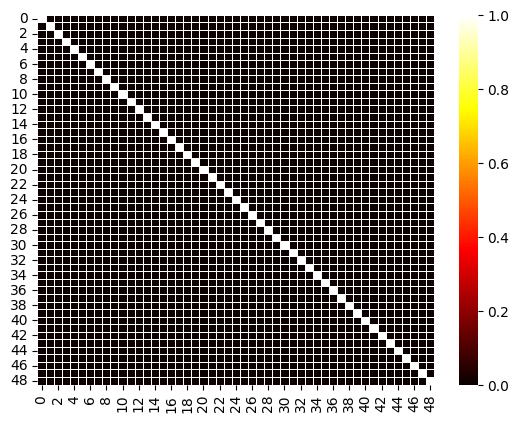

In [7]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

sns.heatmap(cosine_sim, linewidths=.5, cmap='hot')
plt.show()

In [17]:
bert_tokenzier = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device='cpu')
bert_model.eval()

def get_bert_embedding(text):
    tokenziers = bert_tokenzier(text, return_tensors='pt', padding=True, truncation=True).to(device='cpu')
    with torch.no_grad():
        output = bert_model(**tokenziers)
    return output[0][:, 0, :].squeeze(0).numpy()

def get_bert_similarty(text1, text2):
    embedding1 = get_bert_embedding(text1)
    embedding2 = get_bert_embedding(text2)
    return cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0][0]

def get_bert_similarty_list(text, text_list):
    embedding = get_bert_embedding(text)
    embedding_list = [get_bert_embedding(t) for t in text_list]
    return cosine_similarity(embedding.reshape(1, -1), embedding_list)[0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
bert_sim_list = []
for text in tqdm(data_df['hashtag'].tolist()):
    for text_target in data_df['hashtag'].tolist():
        similarity = get_bert_similarty(text, text_target)
        bert_sim_list.append(similarity)

bert_sim_list = np.array(bert_sim_list).reshape(len(data_df), len(data_df))
bert_sim_df = pd.DataFrame(bert_sim_list, columns=data_df['hashtag'].tolist(), index=data_df['hashtag'].tolist())

100%|██████████| 49/49 [04:03<00:00,  4.96s/it]


In [24]:
plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(cosine_sim, annot=True, fmt=".2f", linewidths=.5, cmap='hot')
plt.show()